In [ ]:
!pip install opencv-python
!pip install gdown
!pip install tensorflow-gpu==2.8.3

In [ ]:
!pip install git+https://github.com/tensorflow/docs

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import copy
import math
import gdown
import cv2
import json

import random
from collections import Counter
import os
import shutil
from tensorflow.python.ops.numpy_ops import np_config

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   187M      0  0:00:04  0:00:04 --:--:--  187M
 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [5]:
random.seed(4316)

In [6]:
#Dal momento che Keras non ha una F1-Score built-in, la implementiamo manualmente
#come classe "keras.metrics.Metric"
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1-score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(tf.round(y_pred), tf.float32)

        true_positives = tf.reduce_sum(y_true * y_pred)
        false_positives = tf.reduce_sum((1 - y_true) * y_pred)
        false_negatives = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(true_positives)
        self.false_positives.assign_add(false_positives)
        self.false_negatives.assign_add(false_negatives)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())

        f1_score = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        return f1_score

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.false_positives.assign(0.0)
        self.false_negatives.assign(0.0)

In [7]:
#il dataset ha 1590 immagini corrotte, che vanno eliminate prima di creare gli split
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [8]:
#attraverso la funzione "image_dataset_from_directory" creiamo il subset di training e di validation.
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "PetImages", #Nome della directory da cui prendere le immagini
    image_size = (64, 64), #dimensione delle immagini
    validation_split = 0.3, #percentuale riservata alla validazione
    subset = "training", #subset da prendere, in questo caso Training
    seed = 4316, #seme per avere ogni volta gli stessi split
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "PetImages",
    image_size = (64, 64),
    validation_split = 0.3,
    subset = "validation",
    seed = 4316
)

Found 23410 files belonging to 2 classes.
Using 16387 files for training.
Found 23410 files belonging to 2 classes.
Using 7023 files for validation.


In [9]:
#salviamo le immagini delle due classi del training set in due liste separate per poterle passare
#al modello generativo
class_0 = []
class_1 = []

for images, labels in train_dataset:
    for i in range(len(labels)):
        if labels[i] == 0:
            class_0.append(images[i])
        else:
            class_1.append(images[i])

In [10]:
#con pickle le salviamo sul drive
output_file_path = "/content/drive/MyDrive/dataset_train_dog.pkl"

with open(output_file_path, 'wb') as file:
    pickle.dump(class_1, file)

In [11]:
#dividiamo il validation set ulteriormente per poter riservare 1/3 al test set
val_batches = tf.data.experimental.cardinality(val_ds)
validation_dataset = val_ds.take(2*val_batches//3)
test_dataset = val_ds.skip(2*val_batches//3)

In [12]:
!unzip -q "/content/drive/MyDrive/afhq.zip"

In [21]:
test_set = tf.keras.utils.image_dataset_from_directory(
    directory = "afhq/train", #Nome della directory da cui prendere le immagini
    image_size = (64, 64), #dimensione delle immagini
    validation_split = 0.3, #percentuale riservata alla validazione
    subset = "validation", #subset da prendere, in questo caso Training
    seed = 4316, #seme per avere ogni volta gli stessi split
)

Found 14630 files belonging to 3 classes.
Using 4389 files for validation.


In [22]:
#salviamo le immagini delle due classi in due liste separate
class_0 = []
class_1 = []

for images, labels in test_set:
    for i in range(len(labels)):
        if labels[i] == 0:
            class_0.append(images[i])
        elif labels[i] == 1:
            class_1.append(images[i])

#riconcanteniamo le due classi con i rispettivi vettori di label 0 e 1
test_set = tf.data.Dataset.from_tensor_slices((class_0 + class_1, [0]*len(class_0) + [1]*len(class_1)))

In [25]:
test_set = test_set.shuffle(len(test_set)).batch(32)

In [23]:
#creiamo di una lista per salvare le etichette delle classi
labels = []

#iteriamo attraverso il dataset per ottenere le etichette delle classi
for _, label in test_set.as_numpy_iterator():
    labels.append(label)

#contiamo le etichette
conteggio_classi = Counter(labels)

#stiampiamo il numero di elementi per ciascuna classe
for classe, conteggio in conteggio_classi.items():
    print(f"Classe {classe}: {conteggio} elementi")

Classe 0: 1538 elementi
Classe 1: 1437 elementi


In [9]:
#ottieniamo l'elenco delle etichette delle classi
class_names = train_dataset.class_names

#contiamo il numero di etichette in ogni split
num_classes = len(class_names)

#contiamo il numero di etichette nel training set
train_labels_count = [0] * num_classes
for images, labels in train_dataset:
    for label in labels:
        train_labels_count[label] += 1

#stampiamo il numero di etichette nel training set
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {train_labels_count[i]}")

Cat: 8263
Dog: 8124


In [10]:
validation_labels_count = [0] * num_classes
for images, labels in validation_dataset:
    for label in labels:
        validation_labels_count[label] += 1

#stampiamo il numero di etichette nel validation set
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {validation_labels_count[i]}")

Cat: 2271
Dog: 2401


In [11]:
#ripetiamo lo stesso processo per il test set
test_labels_count = [0] * num_classes
for images, labels in test_dataset:
    for label in labels:
        test_labels_count[label] += 1

# Stampa il numero di etichette nel test set
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {test_labels_count[i]}")

Cat: 1202
Dog: 1149


**SBILANCIAMENTO DEL DATASET**

In [14]:
#salviamo le immagini delle due classi in due liste separate
class_0 = []
class_1 = []

for images, labels in train_dataset:
    for i in range(len(labels)):
        if labels[i] == 0:
            class_0.append(images[i])
        else:
            class_1.append(images[i])

#mescoliamo la classe che vogliamo sbilanciare
random.shuffle(class_1)
#togliamo gli ultimi 3263 elementi della classe
class_1 = class_1[:len(class_1)-3263]

#riconcanteniamo le due classi con i rispettivi vettori di label 0 e 1
unbalanced_train_dataset = tf.data.Dataset.from_tensor_slices((class_0 + class_1, [0]*len(class_0) + [1]*len(class_1)))

In [16]:
#creiamo di una lista per salvare le etichette delle classi
labels = []

#iteriamo attraverso il dataset per ottenere le etichette delle classi
for _, label in unbalanced_train_dataset.as_numpy_iterator():
    labels.append(label)

#contiamo le etichette
conteggio_classi = Counter(labels)

#stiampiamo il numero di elementi per ciascuna classe
for classe, conteggio in conteggio_classi.items():
    print(f"Classe {classe}: {conteggio} elementi")

Classe 0: 8263 elementi
Classe 1: 4861 elementi


In [1]:
#rimescoliamo il dataset e poi lo ridividiamo in batch (quando lo abbiamo diviso in liste separate per sbilanciarlo
#abbiamo rotto la struttura a batch)
unbalanced_train_dataset = unbalanced_train_dataset.shuffle(len(unbalanced_train_dataset)).batch(32)

NameError: ignored

**OVERSAMPLING CON DATA AUGMENTATION**

In [18]:
#creiamo due liste separate per salvare le immagini delle due calssi
class_0 = []
class_1 = []

for images, labels in unbalanced_train_dataset:
    for i in range(len(labels)):
        if labels[i] == 0:
            class_0.append(images[i])
        else:
            class_1.append(images[i])

#definiamo un livello contenente le trasformazioni di data augmentation
data_augmentation = tf.keras.Sequential([
   tf.keras.layers.RandomFlip("horizontal"),
   tf.keras.layers.RandomRotation(0.1),
   tf.keras.layers.RandomZoom(0.2),
   tf.keras.layers.RandomContrast(0.2)]
)

#applichiamo la data augmentation sui campioni della classe da ribilanciare
augmented_class_1 = [data_augmentation(image) for image in class_1]

#numero di campioni da aggiungere
num_samples_to_add = 3263

#scegliamo casualmente 3263 campioni modificati e li concateniamo alla classe sbilanciata
oversampled_class_1 = class_1 + random.choices(augmented_class_1, k=num_samples_to_add)
#concateniamo tutto con le rispettive etichette
augmented_train_dataset = tf.data.Dataset.from_tensor_slices((class_0 + oversampled_class_1, [0]*len(class_0) + [1]*len(oversampled_class_1)))

In [19]:
#creiamo di una lista per salvare le etichette delle classi
labels = []

#iteriamo attraverso il dataset per ottenere le etichette delle classi
for _, label in augmented_train_dataset.as_numpy_iterator():
    labels.append(labels)

#contiamo le etichette
conteggio_classi = Counter(labels)

#stampiamo il numero di elementi per ciascuna classe
for classe, conteggio in conteggio_classi.items():
    print(f"Classe {classe}: {conteggio} elementi")

Classe 0: 8263 elementi
Classe 1: 8124 elementi


In [20]:
#rimescoliamo il dataset e poi lo ridividiamo in batch (quando lo abbiamo diviso in liste separate per sbilanciarlo
#abbiamo rotto la struttura a batch)
augmented_train_dataset = augmented_train_dataset.shuffle(len(augmented_train_dataset)).batch(32)

**OVERSAMPLING CON MODELLO GENERATIVO**

In [34]:
#con pickle carichiamo il sottoinsieme di immagini generate sinteticamente
input_file_path = "/content/drive/MyDrive/dataset_dog.pkl"

with open(input_file_path, 'rb') as file:
    generated = pickle.load(file)

In [35]:
print(generated.shape)

(3263, 64, 64, 3)


In [36]:
#abilitiamo il comportamento di compatibilità di NumPy in TensorFlow
np_config.enable_numpy_behavior()

#salviamo le immagini delle classi in due liste separate
class_0 = []
class_1 = []
#trasformiamo il dataset in una lista per poterla concatenare dopo
generated_1 = generated.tolist()

for images, labels in unbalanced_train_dataset:
    for i in range(len(labels)):
        if labels[i] == 0:
            class_0.append(images[i])
        else:
            class_1.append(images[i])

In [37]:
#concateniamo alle immagini normali quelle generate
generated_class_1 = np.concatenate((class_1, generated_1), axis=0)
print(generated_class_1.shape)

(8124, 64, 64, 3)


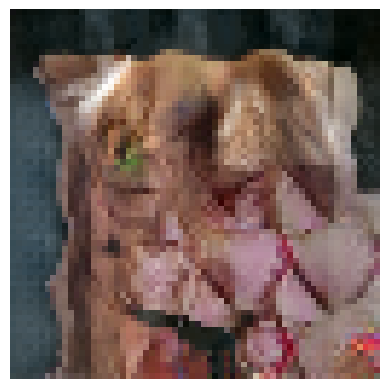

In [38]:
#convertiamo la lista in un array numpy
generated_0 = np.array(generated_class_1)

#selezioniamo l'immagine da visualizzare (ad esempio, la prima immagine)
immagine_da_visualizzare = random.choice(generated_class_1) / 255.0

#visualizziamo l'immagine
plt.imshow(immagine_da_visualizzare)
plt.axis('off')
plt.show()

In [39]:
#concateniamo tutte le immagini per il dataset finale
gen_train_0 = tf.data.Dataset.from_tensor_slices((class_0, [0]*len(class_0)))
gen_train_1 = tf.data.Dataset.from_tensor_slices((generated_class_1, [1]*len(generated_class_1)))

gen_train_1 = gen_train_1.map(lambda immagine, etichetta: (tf.cast(immagine, tf.float32), etichetta))

generated_train_dataset = gen_train_1.concatenate(gen_train_0)

In [40]:
#creiamo una lista per salvare le etichette delle classi
etichette = []

#iteriamo attraverso il dataset per ottenere le etichette delle classi
for _, etichetta in generated_train_dataset.as_numpy_iterator():
    etichette.append(etichetta)

#contiamo le etichette
conteggio_classi = Counter(etichette)

#stampiamo del numero di elementi per ciascuna classe
for classe, conteggio in conteggio_classi.items():
    print(f"Classe {classe}: {conteggio} elementi")

Classe 1: 8124 elementi
Classe 0: 8263 elementi


In [41]:
#rimescoliamo il dataset e poi lo ridividiamo in batch (quando lo abbiamo diviso in liste separate per sbilanciarlo
#abbiamo rotto la struttura a batch)
generated_train_dataset = generated_train_dataset.shuffle(len(generated_train_dataset)).batch(32)

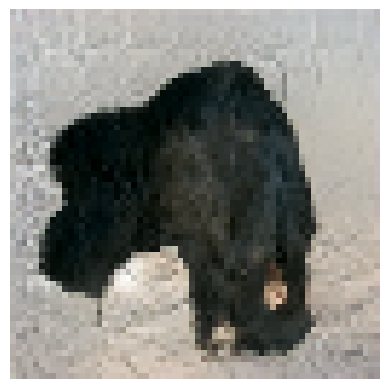

In [60]:
#carichiamo l'immagine utilizzando Matplotlib
lista_batch = list(generated_train_dataset.as_numpy_iterator())
batch = random.choice(lista_batch)
immagine = random.choice(batch[0])

#mostriamo l'immagine utilizzando Matplotlib
immagine_normalizzata = immagine / 255.0
plt.imshow(immagine_normalizzata)
plt.axis('off')
plt.show()

**CLASSIFICAZIONE**

In [30]:
data_augmentation = tf.keras.Sequential([
   tf.keras.layers.RandomFlip("horizontal"),
   tf.keras.layers.RandomRotation(0.3),
   tf.keras.layers.RandomZoom(0.2),
   tf.keras.layers.RandomContrast(0.2)]
)

In [ ]:
#carichiamo la base convolutiva EfficientNetB0
conv_base = tf.keras.applications.EfficientNetB0(weights="imagenet", include_top=False, input_shape = (64, 64, 3))
conv_base.summary()

In [32]:
#sfreeziamo il modello
conv_base.trainable = True
#freeziamo il modello tranne gli ultimi 4 livelli
for layer in conv_base.layers[:-4]:
 layer.trainable = False

In [33]:
inputs = tf.keras.Input(shape=(64, 64, 3))

x = data_augmentation(inputs) #applicazione della data augmentation
x = tf.keras.applications.efficientnet.preprocess_input(x) #scaling dei valori

x = conv_base(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

In [29]:
del model

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1Score()])

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="fine_tuning.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(generated_train_dataset, epochs=90, validation_data=validation_dataset, callbacks=callbacks)

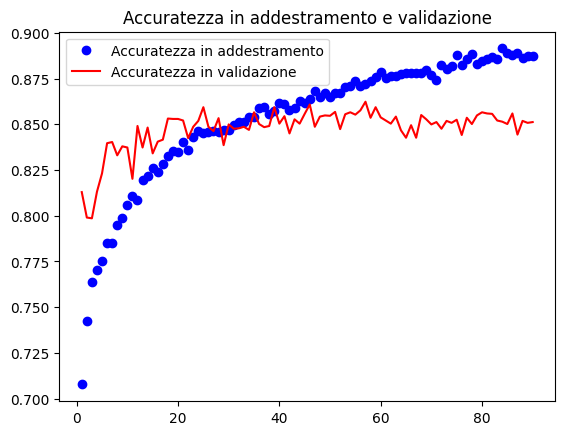

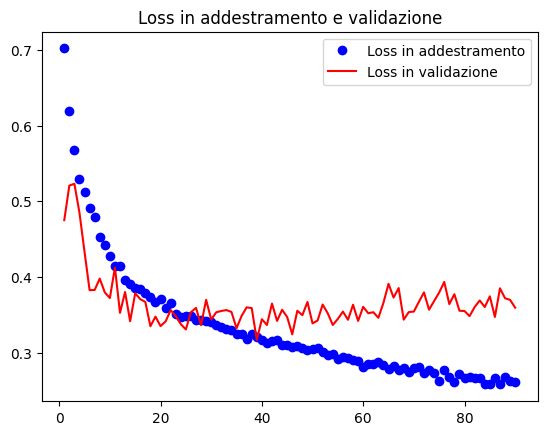

In [43]:
normal_accuracy = history.history["accuracy"]
normal_val_accuracy = history.history["val_accuracy"]

normal_loss = history.history["loss"]
normal_val_loss = history.history["val_loss"]

epochs = range(1, len(normal_accuracy) + 1)

plt.plot(epochs, normal_accuracy, "bo", label="Accuratezza in addestramento")
plt.plot(epochs, normal_val_accuracy, "r", label="Accuratezza in validazione")
plt.title("Accuratezza in addestramento e validazione")
plt.legend()

plt.figure()

plt.plot(epochs, normal_loss, "bo", label="Loss in addestramento")
plt.plot(epochs, normal_val_loss, "r", label="Loss in validazione")
plt.title("Loss in addestramento e validazione")
plt.legend()

plt.show()

In [26]:
test_model = tf.keras.models.load_model("bal_model.keras", custom_objects={'F1Score': F1Score})
test_loss, test_acc, test_prec, test_rec, test_f1 = test_model.evaluate(test_set)
train_loss, train_acc, train_prec, train_rec, train_f1 = test_model.evaluate(train_dataset)
val_loss, val_acc, val_prec, val_rec, val_f1 = test_model.evaluate(validation_dataset)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.3f} Test precision: {test_prec:.3f} Test recall: {test_rec:.3f} Test f1-score: {test_f1:.3f}")
print(f"Train loss: {train_loss:.3f} Train accuracy: {train_acc:.3f} Train precision: {train_prec:.3f} Train recall: {train_rec:.3f} Train f1-score: {train_f1:.3f}")
print(f"Validation loss: {val_loss:.3f} Validation accuracy: {val_acc:.3f} Validation precision: {val_prec:.3f} Validation recall: {val_rec:.3f} Validation f1-score: {val_f1:.3f}")

146/146 [==============================] - 3s 20ms/step - loss: 0.2923 - accuracy: 0.8737 - precision_3: 0.8943 - recall_3: 0.8548 - f1-score: 0.8741
Test loss: 0.178 Test accuracy: 0.926 Test precision: 0.980 Test recall: 0.864 Test f1-score: 0.919
Train loss: 0.250 Train accuracy: 0.894 Train precision: 0.908 Train recall: 0.876 Train f1-score: 0.891
Validation loss: 0.292 Validation accuracy: 0.874 Validation precision: 0.894 Validation recall: 0.855 Validation f1-score: 0.874


In [27]:
test_model = tf.keras.models.load_model("unbal_model.keras", custom_objects={'F1Score': F1Score})
test_loss, test_acc, test_prec, test_rec, test_f1 = test_model.evaluate(test_set)
train_loss, train_acc, train_prec, train_rec, train_f1 = test_model.evaluate(train_dataset)
val_loss, val_acc, val_prec, val_rec, val_f1 = test_model.evaluate(validation_dataset)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.3f} Test precision: {test_prec:.3f} Test recall: {test_rec:.3f} Test f1-score: {test_f1:.3f}")
print(f"Train loss: {train_loss:.3f} Train accuracy: {train_acc:.3f} Train precision: {train_prec:.3f} Train recall: {train_rec:.3f} Train f1-score: {train_f1:.3f}")
print(f"Validation loss: {val_loss:.3f} Validation accuracy: {val_acc:.3f} Validation precision: {val_prec:.3f} Validation recall: {val_rec:.3f} Validation f1-score: {val_f1:.3f}")

146/146 [==============================] - 3s 22ms/step - loss: 0.3037 - accuracy: 0.8658 - precision_2: 0.8596 - recall_2: 0.8835 - f1-score: 0.8714
Test loss: 0.173 Test accuracy: 0.931 Test precision: 0.957 Test recall: 0.897 Test f1-score: 0.926
Train loss: 0.269 Train accuracy: 0.885 Train precision: 0.870 Train recall: 0.904 Train f1-score: 0.887
Validation loss: 0.304 Validation accuracy: 0.866 Validation precision: 0.860 Validation recall: 0.884 Validation f1-score: 0.871


In [28]:
test_model = tf.keras.models.load_model("aug_model.keras", custom_objects={'F1Score': F1Score})
test_loss, test_acc, test_prec, test_rec, test_f1 = test_model.evaluate(test_set)
train_loss, train_acc, train_prec, train_rec, train_f1 = test_model.evaluate(train_dataset)
val_loss, val_acc, val_prec, val_rec, val_f1 = test_model.evaluate(validation_dataset)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.3f} Test precision: {test_prec:.3f} Test recall: {test_rec:.3f} Test f1-score: {test_f1:.3f}")
print(f"Train loss: {train_loss:.3f} Train accuracy: {train_acc:.3f} Train precision: {train_prec:.3f} Train recall: {train_rec:.3f} Train f1-score: {train_f1:.3f}")
print(f"Validation loss: {val_loss:.3f} Validation accuracy: {val_acc:.3f} Validation precision: {val_prec:.3f} Validation recall: {val_rec:.3f} Validation f1-score: {val_f1:.3f}")

146/146 [==============================] - 4s 25ms/step - loss: 0.2955 - accuracy: 0.8759 - precision_4: 0.8877 - recall_4: 0.8676 - f1-score: 0.8775
Test loss: 0.168 Test accuracy: 0.931 Test precision: 0.960 Test recall: 0.894 Test f1-score: 0.926
Train loss: 0.257 Train accuracy: 0.892 Train precision: 0.897 Train recall: 0.883 Train f1-score: 0.890
Validation loss: 0.295 Validation accuracy: 0.876 Validation precision: 0.888 Validation recall: 0.868 Validation f1-score: 0.878


In [29]:
test_model = tf.keras.models.load_model("gen_model.keras", custom_objects={'F1Score': F1Score})
test_loss, test_acc, test_prec, test_rec, test_f1 = test_model.evaluate(test_set)
train_loss, train_acc, train_prec, train_rec, train_f1 = test_model.evaluate(train_dataset)
val_loss, val_acc, val_prec, val_rec, val_f1 = test_model.evaluate(validation_dataset)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.3f} Test precision: {test_prec:.3f} Test recall: {test_rec:.3f} Test f1-score: {test_f1:.3f}")
print(f"Train loss: {train_loss:.3f} Train accuracy: {train_acc:.3f} Train precision: {train_prec:.3f} Train recall: {train_rec:.3f} Train f1-score: {train_f1:.3f}")
print(f"Validation loss: {val_loss:.3f} Validation accuracy: {val_acc:.3f} Validation precision: {val_prec:.3f} Validation recall: {val_rec:.3f} Validation f1-score: {val_f1:.3f}")

146/146 [==============================] - 3s 20ms/step - loss: 0.3147 - accuracy: 0.8664 - precision: 0.8822 - recall: 0.8543 - f1-score: 0.8680
Test loss: 0.145 Test accuracy: 0.942 Test precision: 0.959 Test recall: 0.919 Test f1-score: 0.938
Train loss: 0.257 Train accuracy: 0.893 Train precision: 0.895 Train recall: 0.887 Train f1-score: 0.891
Validation loss: 0.315 Validation accuracy: 0.866 Validation precision: 0.882 Validation recall: 0.854 Validation f1-score: 0.868


In [45]:
history_dict = history.history
with open('training_history.json', 'w') as json_file:
    json.dump(history_dict, json_file)

**PLOT DEI GRAFICI**

<Figure size 640x480 with 0 Axes>

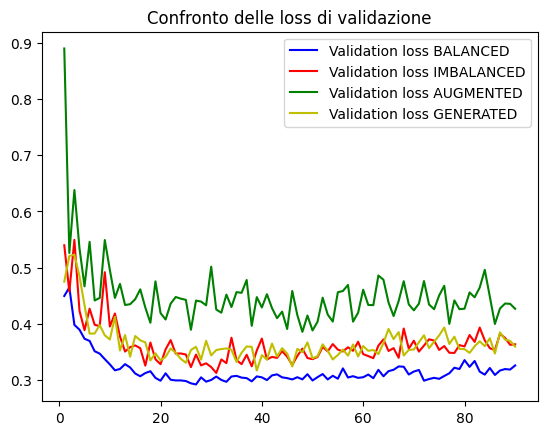

<Figure size 640x480 with 0 Axes>

In [56]:
# Carica il file JSON
with open('bal_history.json', 'r') as f:
    bal_history = json.load(f)
with open('unbal_history.json', 'r') as f:
    unbal_history = json.load(f)
with open('aug_history.json', 'r') as f:
    aug_history = json.load(f)
with open('gen_history.json', 'r') as f:
    gen_history = json.load(f)

# Accedi ai dati della history
bal_loss = bal_history['loss']
bal_acc = bal_history['accuracy']
bal_val_loss = bal_history['val_loss']
bal_val_acc = bal_history['val_accuracy']

# Accedi ai dati della history
unbal_loss = unbal_history['loss']
unbal_acc = unbal_history['accuracy']
unbal_val_loss = unbal_history['val_loss']
unbal_val_acc = unbal_history['val_accuracy']

# Accedi ai dati della history
aug_loss = aug_history['loss']
aug_acc = aug_history['accuracy']
aug_val_loss = aug_history['val_loss']
aug_val_acc = aug_history['val_accuracy']

# Accedi ai dati della history
gen_loss = gen_history['loss']
gen_acc = gen_history['accuracy']
gen_val_loss = gen_history['val_loss']
gen_val_acc = gen_history['val_accuracy']

plt.plot(epochs, bal_val_loss, "b", label="Validation loss BALANCED")
plt.plot(epochs, unbal_val_loss, "r", label="Validation loss IMBALANCED")
plt.plot(epochs, aug_val_loss, "g", label="Validation loss AUGMENTED")
plt.plot(epochs, gen_val_loss, "y", label="Validation loss GENERATED")
plt.title("Confronto delle loss di validazione")
plt.legend()

plt.figure()

<Figure size 640x480 with 0 Axes>

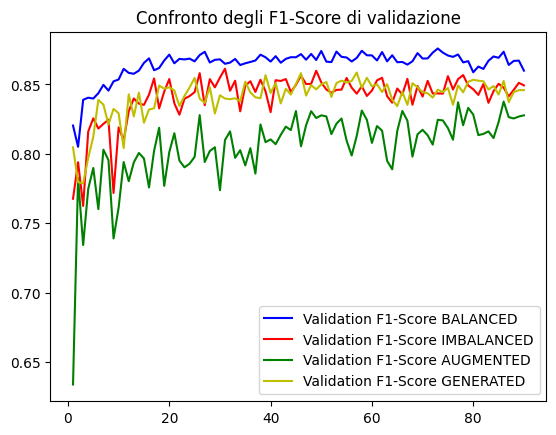

<Figure size 640x480 with 0 Axes>

In [57]:
bal_val_f1 = bal_history['val_f1-score']
unbal_val_f1 = unbal_history['val_f1-score']
aug_val_f1 = aug_history['val_f1-score']
gen_val_f1 = gen_history['val_f1-score']

plt.plot(epochs, bal_val_f1, "b", label="Validation F1-Score BALANCED")
plt.plot(epochs, unbal_val_f1, "r", label="Validation F1-Score IMBALANCED")
plt.plot(epochs, aug_val_f1, "g", label="Validation F1-Score AUGMENTED")
plt.plot(epochs, gen_val_f1, "y", label="Validation F1-Score GENERATED")
plt.title("Confronto degli F1-Score di validazione")
plt.legend()

plt.figure()